<a href="https://colab.research.google.com/github/zyonit/facial_landmarks/blob/main/data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *  
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
import os
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import gdown
url = 'https://drive.google.com/uc?id=1hzBd48JIdWTJSsATBEB_eFVvPL1bx6UC'
output = 'WFLW.tar.gz'
gdown.download(url, output, quiet=False) 

Downloading...
From: https://drive.google.com/uc?id=1hzBd48JIdWTJSsATBEB_eFVvPL1bx6UC
To: /content/WFLW.tar.gz
145MB [00:00, 99.4MB/s]

KeyboardInterrupt: ignored

In [ ]:
!wget https://wywu.github.io/projects/LAB/support/WFLW_annotations.tar.gz

In [4]:
!tar -xf WFLW.tar.gz
!tar -xf WFLW_annotations.tar.gz

In [5]:
print(os.getcwd())

/content


In [102]:
train_metadatapath = r"list_98pt_rect_attr_train.txt"
test_metadatapath = r"list_98pt_rect_attr_test.txt"
images_dir = r"WFLW_images"
# images_dir = r"test_images"


In [103]:
class Rescale(object):
  """Rescale the image in a sample to a given size square image.
  Args:output_size (int): Desired output size (output_size x output_size). 
"""

  def __init__(self, output_size):
      self.output_size = output_size

  def __call__(self, sample):
      image, landmarks = sample['images'], sample['landmarks']
      h, w = image.shape[:2]
      img = transform.resize(image, (self.output_size, self.output_size))
      # h and w are swapped for landmarks because for images,
      # x and y axes are axis 1 and 0 respectively
      sample['images'] = img
      return sample


class rotate(object):
  """rotates the image in angle between -maxangle and +maxangle).
  Args:maxangle (int): maxangle. 
  Note - This augentation works well after performing a crop and a resizeing of the image to a square size

"""

  def __init__(self, maxangle):
    self.maxangle = maxangle 
  def __call__(self, sample ):
    angle =  random.uniform(-self.maxangle, +self.maxangle)
    image = sample['images']
    transformation_matrix = torch.tensor([
      [+cos(radians(angle)), -sin(radians(angle))],
      [+sin(radians(angle)), +cos(radians(angle))]
    ])

    image = imutils.rotate(np.array(image), angle)
    sample['images'] = image

    if 'landmarks' in sample:
      landmarks = sample['landmarks'] - 0.5
      new_landmarks = np.matmul(landmarks, transformation_matrix)
      new_landmarks = new_landmarks + 0.5
      sample['landmarks'] = new_landmarks

    return sample


class crop_face(object):
  """crops the image according to the bounfing box values that were given in the metadata file.
  in addition, we can add a variability value between 0-1 that defines the variation of the bounding box cropping. recommended to use a low value ~ 0.05!
"""

  def __init__(self, crop_variability= False , max_variability=0.05):
    self.max_variability =max_variability
    self.crop_variability = crop_variability
  def __call__(self, sample ):
        image, landmarks, crops = sample['images'], sample['landmarks'], sample['crops']
        image_h, image_w = image.shape[:2]
        left = crops[0]
        top = crops[1]
        bbox_width = crops[2]-crops[0]
        bbox_height = crops[3]-crops[1]
      
        if self.crop_variability:
          left_difference = int(random.uniform(-self.max_variability*bbox_width, +self.max_variability*bbox_width))
          width_difference = int(random.uniform(-self.max_variability*bbox_width, +self.max_variability*bbox_width))
          
          height_difference = int(random.uniform(-self.max_variability*bbox_height, +self.max_variability*bbox_height))
          top_difference = int(random.uniform(-self.max_variability*bbox_height, +self.max_variability*bbox_height))


          new_left = (left+left_difference) if (left+left_difference)>0 else left
          new_top = (top+top_difference) if (top+top_difference)>0 else top
        
          new_bbox_width = bbox_width+width_difference
          new_bbox_height = bbox_height + height_difference

          if((new_top + new_bbox_height) >image_h or (new_top + new_bbox_height)<0  ):
            new_top = top
            new_bbox_height = bbox_height

          if((new_left + new_bbox_width) >image_w or (new_left + new_bbox_width) <0  ):
            new_left = left
            new_bbox_width = bbox_width

          image = image[ new_top:new_top +new_bbox_height ,
                        new_left:new_left +new_bbox_width ]      
          landmarks = landmarks - torch.tensor([new_left, new_top])
          landmarks = landmarks /torch.tensor( [image.shape[1], image.shape[0]])

        else:
          image = image[ top:top +bbox_height ,
                        left:left +bbox_width ]      
          landmarks = landmarks - torch.tensor([left, top])
          landmarks = landmarks /torch.tensor( [image.shape[1], image.shape[0]])         
        sample['images'] = image
        sample['landmarks'] = landmarks
        return sample

class color_jitter(object):
  """Randomly change the brightness, contrast and saturation of an image.
  in this augmentation  we convert the np array to pill in order to use transforms  
"""

  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    im_pil = Image.fromarray((image* 255).astype(np.uint8))
    color_jitter = transforms.ColorJitter(brightness=0.1,
                                      contrast=0.1,
                                      saturation=0.1,
                                      hue=0.1)
    pill_img_aug = color_jitter(im_pil) 
    sample['images'] =pill_img_aug

    return sample

class ToTensor(object):
  """ToTensor.
"""
  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    
    ToTensor = transforms.ToTensor()
    tensor_img = ToTensor(image) 
    sample['images'] =tensor_img
    return sample

class imagenetNormalize(object):
  """ToTensor.
"""
  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    imagenet_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    norm_image = imagenet_norm(image) 
    sample['images'] =norm_image
    return sample

class Normalize(object):
  """ToTensor.
"""
  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    images_norm = transforms.Normalize(mean=[0.5595, 0.4268, 0.3663],
                             std=[0.2584, 0.2369, 0.2182])
    norm_image = images_norm(image) 
    sample['images'] =norm_image
    return sample


In [104]:
class FaceLandmarksDataset(Dataset):

    def __init__(self,images_dir, metadatapath, transform=None, include_landmarks=True):

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.metadatapath = metadatapath
        self.images_dir = images_dir
        with open(self.metadatapath, 'r') as filehandle:
            for line in filehandle:
                # remove linebreak which is the last character of the string
                face_instance = line[:-1].split(' ')
                self.image_filenames.append( face_instance[-1])
                # self.landmarks.append([float(i) for i in face_instance[:196]] )
                # self.crops.append([float(i) for i in face_instance[196:200]] )
                self.crops.append(list(map(int,face_instance[196:200])))
                if include_landmarks:
                  landmark = []
                  for num in range(98):
                      x_coordinate = (float(face_instance[num*2]))
                      y_coordinate = float(face_instance[num*2 + 1])
                      landmark.append(list(map(int,[x_coordinate, y_coordinate])))
                  self.landmarks.append(landmark)
        if include_landmarks:
          self.landmarks =  torch.as_tensor(self.landmarks , dtype=torch.float)
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_dir, self.image_filenames[index])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = io.imread(img_name)
        landmarks = self.landmarks[index]
        crops = self.crops[index]
        sample = {'images': image, 'landmarks': landmarks , 'crops':crops }
        if self.transform:
            sample = self.transform(sample)

        sample['landmarks'] = sample['landmarks'] - 0.5

        return sample

In [105]:
def visualize_dataset(dataset , w,h, num_images = 4):
  rows = ceil(num_images/4)
  fig = plt.figure(figsize=(w, h))
  for i in range(num_images):
      sample = dataset[i]
      image, landmarks = sample['images'] , sample['landmarks']
      image = image.permute(1, 2, 0)
      shape =  image.shape
      fig.add_subplot(rows, 4, i+1)
      plt.imshow(image)
      plt.scatter((landmarks[:, 0] +0.5)*shape[1], (landmarks[:, 1] + 0.5)*shape[0], s=30, marker='.', c='r')
  plt.show()
  return


In [106]:
train_augmentations = transforms.Compose([crop_face(),Rescale(224), rotate(10), color_jitter(), ToTensor(), Normalize()])
dataset = FaceLandmarksDataset(images_dir, train_metadatapath, transform=train_augmentations)

raw_data_transforms = transforms.Compose([crop_face(),Rescale(224), ToTensor()])
raw_data_dataset = FaceLandmarksDataset(images_dir, train_metadatapath, transform=raw_data_transforms)

test_augmentations = transforms.Compose([crop_face(),Rescale(224), ToTensor(), Normalize()])
test_dataset = FaceLandmarksDataset(r"test_images", r"outputAnnotationsYonit.txt", transform=test_augmentations)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


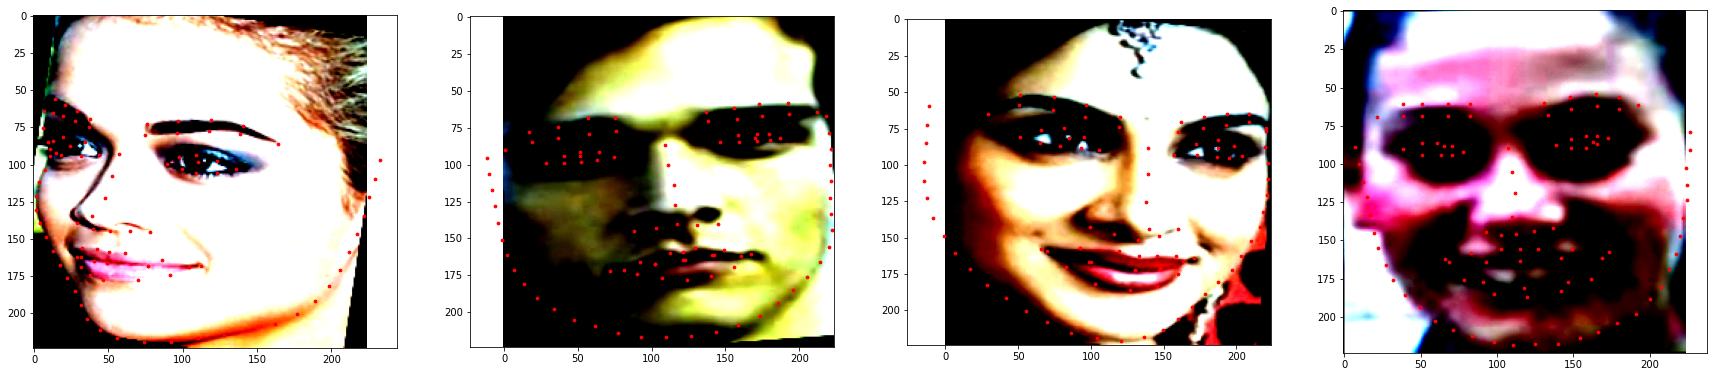

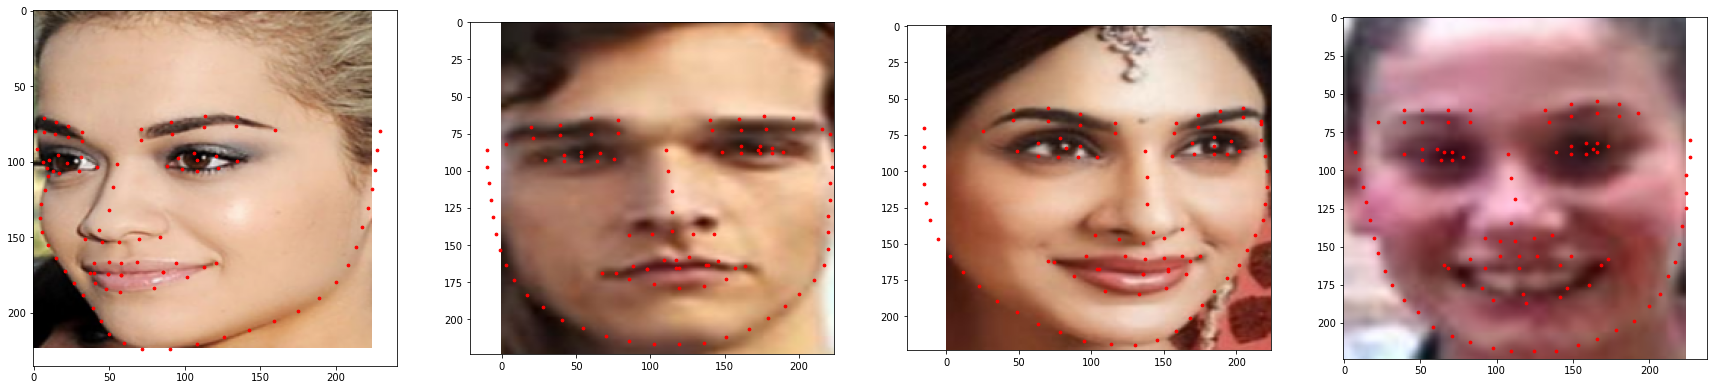

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


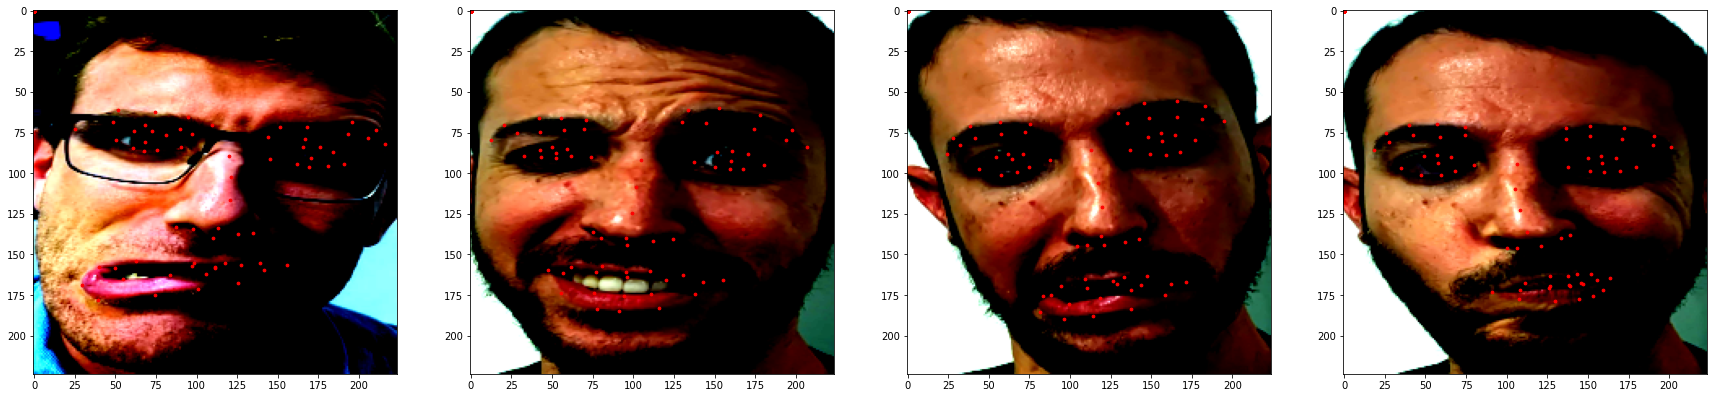

In [107]:

visualize_dataset(dataset, 30, 30)
visualize_dataset(raw_data_dataset, 30, 30)
visualize_dataset(test_dataset, 30, 30)


##split data

In [111]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)


The length of Train set is 6750
The length of Valid set is 750




```
# calculated mean and std of dataset for normalization parameters
```



In [112]:

# from tqdm import tqdm
# N_CHANNELS = 3
# mean = torch.zeros(N_CHANNELS)
# std = torch.zeros(N_CHANNELS)
# print('==> Computing mean and std..')
# for sample  in tqdm(train_loader):
#     images = sample['images']
#     for i in range(N_CHANNELS):
#         mean[i] += images[:,i,:,:].mean()
#         std[i] += images[:,i,:,:].std()
# mean.div_(106)
# std.div_(106) # this number changes according to batch size. it was 64 when I wrote the code
# print(mean, std)


In [113]:
# !pip install tqdm

In [114]:
sample = next(iter(train_loader))

print(sample['images'].shape)
print(sample['landmarks'].shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 98, 2])


## Define the model

In [115]:
class Network(nn.Module):
    def __init__(self,num_classes=98*2):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        # self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [116]:
 Network()

Network(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

## Helper Functions

In [117]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

## Train

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
        sample =  next(iter(train_loader))
        images, landmarks = sample['images'] , sample['landmarks']
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            sample =  next(iter(valid_loader))
            images, landmarks = sample['images'] , sample['landmarks']
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

Train Steps: 127/844  Loss: 0.0149 

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7ebc9965c0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


Train Steps: 130/844  Loss: 0.0146 

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f7ebd45ac18>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


Train Steps: 527/844  Loss: 0.0039 

## Predict on Test Images

Total number of test images: 750
Elapsed Time : 1.480116844177246


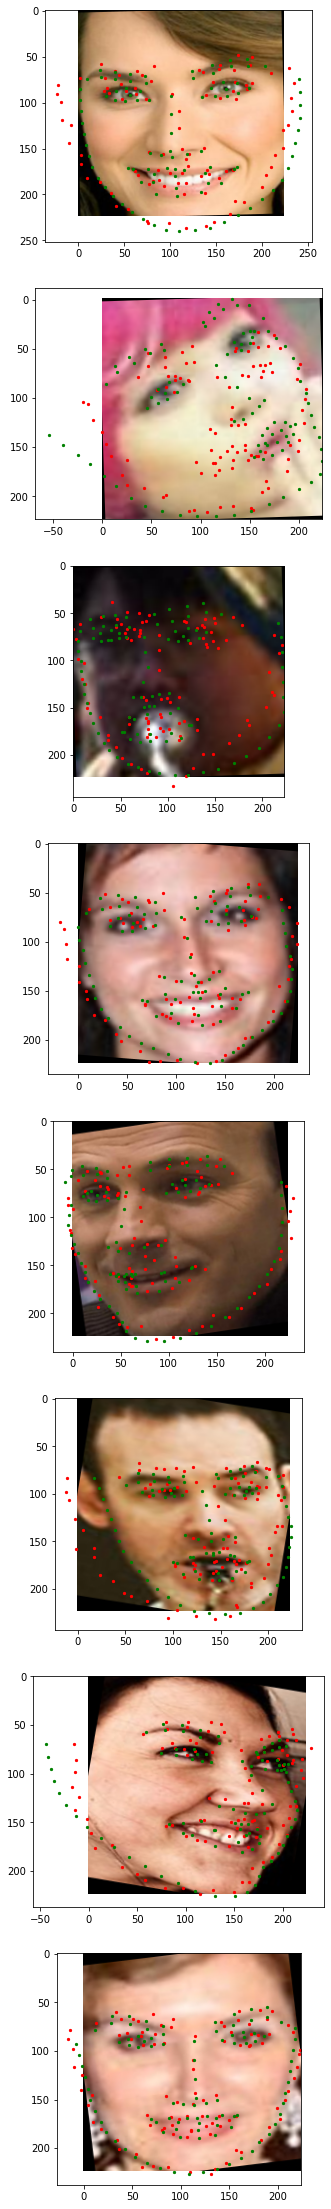

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,98,2)
    
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(cv2.cvtColor(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cv2.COLOR_BGR2RGB) )
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

In [ ]:
train_metadatapath = r"outputAnnotations_clean.txt"
test_metadatapath = r"outputAnnotations_clean.txt"
images_path = r"annotated"

In [ ]:
test_dataset = FaceLandmarksDataset(train= False , transform=Transforms())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4)
images, landmarks = next(iter(test_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([8, 3, 224, 224])
torch.Size([8, 98, 2])


tensor([[[ -2.4635,  75.7153],
         [ -3.3551,  86.9777],
         [  1.4162,  93.7676],
         ...,
         [ 73.3890, 167.5855],
         [ 65.1343,  85.6433],
         [168.5525, 100.6196]],

        [[-14.4356,  98.2436],
         [-12.4551, 114.9344],
         [ -7.8875, 117.6145],
         ...,
         [116.5720, 175.5031],
         [ 70.9721,  96.0542],
         [179.3273,  91.7150]],

        [[-18.4303,  86.9581],
         [-21.3577,  97.8604],
         [-17.3178, 108.0961],
         ...,
         [ 87.2377, 181.0557],
         [ 56.2618,  82.4988],
         [171.2447,  85.9996]],

        ...,

        [[-13.3814,  58.7837],
         [ -7.2229,  71.8285],
         [-14.3752,  79.3479],
         ...,
         [ 51.6693, 166.7258],
         [ 57.7687,  79.4125],
         [154.2639,  96.6379]],

        [[ -9.2170,  62.7664],
         [-10.3384,  75.6160],
         [ -9.1602,  83.9397],
         ...,
         [ 53.1592, 172.8057],
         [ 47.0331,  75.5477],
         

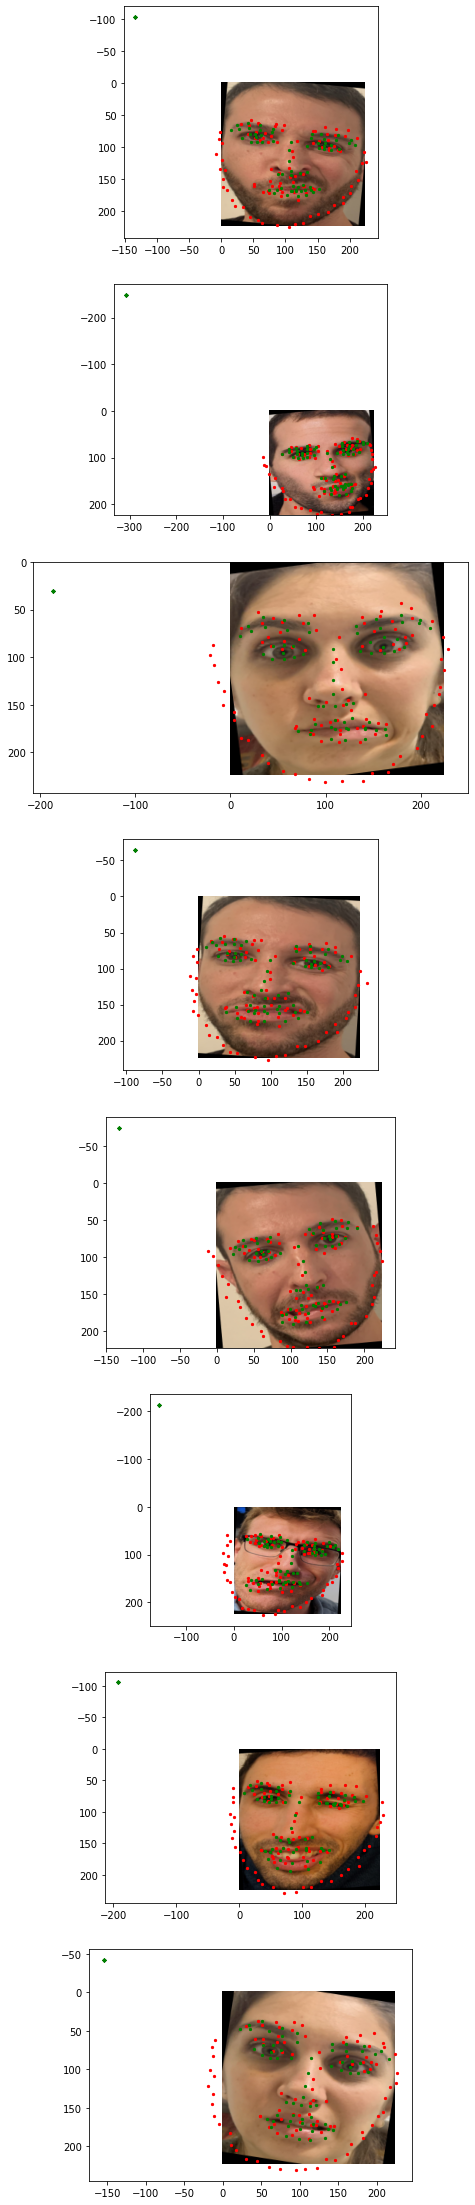

In [ ]:
start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(test_loader))
    
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,98,2)
    print(predictions)
    plt.figure(figsize=(10,40))
    
    for img_num in range(8):
        plt.subplot(8,1,img_num+1)
        plt.imshow(cv2.cvtColor(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cv2.COLOR_BGR2RGB) )
        plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 